## Deep Learning Visualization

Explore some methods to visualize what a Convolutional Neural Network 'sees'.

- Feature maps
- Occlusion maps
- Saliency maps
- Feature visualization

This notebook loads a VGG16 classification model trained on Imagenet. You can play around with the different visualization methods, look at different layers, different channels, different input images and output classes, ...

As an extra exercise, you can try to implement the methods in this notebook on your own model.

#### Further reading / extra links

https://distill.pub/2017/feature-visualization/

https://github.com/tensorflow/lucid

https://github.com/jacobgil/pytorch-grad-cam

https://captum.ai/

https://github.com/rdaems/feature_visualization/blob/master/feature_visualization.py

In [1]:
# import json
import tensorflow as tf
from tensorflow.keras import backend as K
import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.ndimage import affine_transform

### Load a trained model

The cell below will load a VGG16 model trained on Imagenet.
Please note that the model has a corresponding `preprocess` function. The model will expect images in a specific modality, which is exactly the same as used when this model was trained. This includes how the pixel values where mapped from `uint8` (0, 255) to `float32` e.g (0., 1.), or even a switch from RGB to BGR.

It's very important that you get this preprocess function correct, otherwise the model and methods below will not function properly.

In [2]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
preprocess = tf.keras.applications.vgg16.preprocess_input

model.summary()

2022-02-16 16:54:22.620986: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-16 16:54:22.621008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hippo-one
2022-02-16 16:54:22.621012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hippo-one
2022-02-16 16:54:22.621056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-16 16:54:22.621070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-16 16:54:22.621074: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-16 16:54:22.621282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Images

Load some example images for the methods that work with an input image. Feel free to add some url's or local paths.

The images are cropped to a square (224x224) because that's the image size in the Imagenet dataset.
The VGG16 model expects images with this shape, due to the flatten operation and fully connected layers at the top.

You can add `include_top=False` to the model loading function above to get a shape invariant VGG16 model. Because every layer before the top is shape invariant (fully convolutional). But then you lose the class outputs.

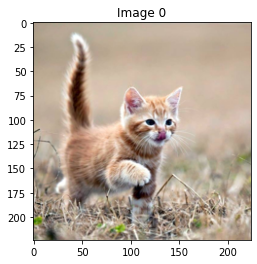

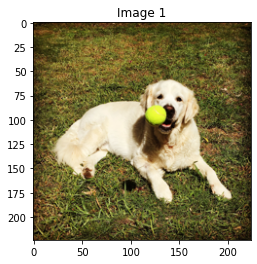

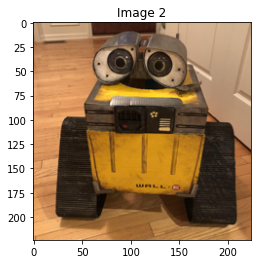

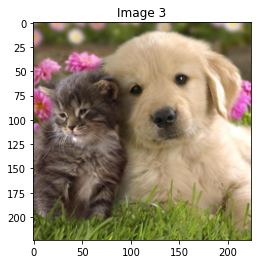

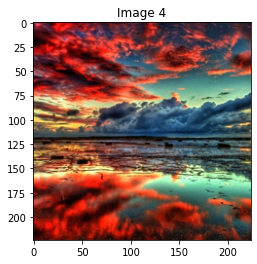

In [3]:
# load example images
paths = [
    'https://i.imgur.com/erFQJZi.jpeg',
    'https://i.imgur.com/uZvgFyQ.jpeg',
    'https://i.imgur.com/bGscw8I.jpeg',
    'https://i.pinimg.com/originals/0f/0d/87/0f0d87779573583b11643cde62767ab3.jpg',
    'https://i.imgur.com/rBkbXS3.jpeg',
]

def load_image(path):
    image = imageio.imread(path)
    h, w, _ = image.shape
    s = min(h, w)
    i0 = (h - s) // 2
    i1 = i0 + s
    j0 = (w - s) // 2
    j1 = j0 + s
    image = image[i0:i1, j0:j1, :]
    image = Image.fromarray(image)
    image.thumbnail((224, 224))
    return np.array(image)

images = [load_image(path) for path in paths]

for i, image in enumerate(images):
    plt.imshow(image)
    plt.title(f'Image {i}')
    plt.show()

### Feature maps

Take a look at the intermediary feature representations in the model. You can choose an input image and a layer, and all the feature outputs of that layer will be shown in a grid.

Specific filters will respond to specific colors, textures, patterns or objects in the input image. The first layers act as edge or color filters. Later layers in the model will have a lower resolution due to the pooling operations, and will respond to more abstract semantic properties, because the information was processed by more convolution layers.

In [4]:
def grid(features, num_cols=None, margin=0.1):
    cm = plt.get_cmap('plasma')
    def normalize(x):
        x = (x - x.min()) / (x.max() - x.min())
        return x
    h, w, c = features.shape
    margin = int(np.ceil(w * margin))
    features = normalize(features)
    features = cm(features)[..., :3]
    features = (255 * features).astype(np.uint8)
    if num_cols is None:
        num_cols = int(np.sqrt(c))
    num_rows = int(np.ceil(c / num_cols))
    canvas = np.zeros((num_rows * (h + margin) + margin, num_cols * (w + margin) + margin, 3), dtype=np.uint8)
    for k in range(c):
        i = k // num_cols
        j = k % num_cols
        i0 = margin + i * (h + margin)
        j0 = margin + j * (w + margin)
        i1 = i0 + h
        j1 = j0 + w
        canvas[i0:i1, j0:j1, ...] = features[:, :, k]
    return canvas

def grid_view(*args, **kwargs):
    g = grid(*args, **kwargs)
    h, w, _ = g.shape
    s = int(2000 / w)
    s = max(s, 1)
    im = Image.fromarray(g)
    im = im.resize((s * w, s * h), Image.NEAREST)
    display(im)

In [5]:
@interact(image=range(len(images)), layer=[layer.name for layer in model.layers])
def f(image, layer):
    x = preprocess(images[image])
    feature_layer = model.get_layer(layer)
    f = K.function([model.input], [feature_layer.output])
    features = f(x[None])[0].squeeze()

    grid_view(features, num_cols=8)

interactive(children=(Dropdown(description='image', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='l…

### Occlusion maps

What regions in the image contribute most to a classfication decision? Occlusion maps allow to estimate this in a simple way. A gray square is moved around the image, and for every position the model classifies this masked input image. If the classification score drops, we know that there was information masked by the gray square that contributed to this score.

You can find the class names [here](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). Look for object classes present in the images, such as golden retriever (207) and tennisball (852).

*This might take some time to run on CPU, be patient.*

In [6]:
@interact(image=range(len(images)), class_index=range(1000))
def f(image, class_index):
    s = 16
    x = images[image]
    h, w, c = x.shape
    masks = []
    for i in range(s // 2, h, s):
        for j in range(s // 2, w, s):
            mask = x.copy()
            i0 = max(0, i - s // 2)
            i1 = min(h, i + s // 2)
            j0 = max(0, j - s // 2)
            j1 = min(w, j + s // 2)
            mask[i0:i1, j0:j1] = 127
            masks.append(mask)

    x = preprocess(np.array(masks))
    y = model(x)
    output = np.array(- y[:, class_index])
    output = output.reshape(h // s, w // s)
    plt.imshow(images[image])
    plt.show()
    plt.imshow(output)
    plt.show()

interactive(children=(Dropdown(description='image', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='c…

### Saliency maps

Autograd libraries such as TensorFlow will automagically calculate the gradients of a loss function all the way back to the model weights, but they can do a lot more! In fact you can get the gradient of any operation.

This method is similar in purpose to the oclussion method above, but makes use of the gradients. By taking the gradient of a class probability score back to the input image, you get a gradient 'image' which shows the contribution (or sensitivity) of any pixel to the class score. Thanks to autograd, you only have to calculate this once, so this is a lot faster than the occlusion maps method (where the model output had to be calculated for every mask position).

In [7]:
@interact(image=range(len(images)), class_index=range(1000))
def f(image, class_index):
    x = preprocess(images[image])
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x[None])[:, class_index]
        grad = tape.gradient(y, x)

    scale = np.max(np.abs(grad))
    plt.imshow(images[image])
    plt.show()
    plt.imshow(0.5 + grad / scale / 2)
    plt.show()

interactive(children=(Dropdown(description='image', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='c…

### Feature visualization

Now let's use gradients for feature visualization! We can visualize what a specific filter in a specific layer is focussing on, by optimizing an input image that maximizes this filter's activation. We start with a random, gray image and iteratively optimize to increase the filter output with gradient ascent.

Choose a layer and filter (unit) below. This will take some time to optimize, please be patient.
It's interesting to compare this method with the feature maps in the first method. If you see certain patterns or objects highly activating a specific filter in the feature maps, similar patters should emerge here as well.

Simply doing the optimization gives results with high frequency noise and unrealistic colors, because that's the easiest way to increase feature activation. A number of tricks is used to improve the optimization and render more interpretable images with realistic colors.
You can read more about that [here](https://distill.pub/2017/feature-visualization/).

In [8]:
def get_transformation_matrix():
    # values from https://distill.pub/2017/feature-visualization/#d-footnote-9
#     j1 = (np.random.randint(-16, 17), np.random.randint(-16, 17))
#     s = np.random.choice([1, 0.975, 1.025, 0.95, 1.05])
#     r = np.random.randint(-5, 6)
#     j2 = (np.random.randint(-8, 9), np.random.randint(-8, 9))

    # # a bit less heavy
    j1 = (np.random.randint(-4, 7), np.random.randint(-4, 7))
    s = np.random.choice([1, 0.975, 1.025])
    r = np.random.randint(-5, 6)
    j2 = (np.random.randint(-2, 3), np.random.randint(-2, 3))

    J1 = np.eye(3)
    J1[0:2, 2] = j1
    S = np.eye(3)
    S[0, 0] = s
    S[1, 1] = s
    R = np.eye(3)
    R[0:2, 0:2] = [[np.cos(np.radians(r)), -np.sin(np.radians(r))], [np.sin(np.radians(r)), np.cos(np.radians(r))]]
    J2 = np.eye(3)
    J2[0:2, 2] = j2
    T = J2 @ R @ S @ J1
    return T


def transform_image(image, T, origin='center', inverse=False):
    # image: 2 or 3 dimensional image (h, w, c)
    # T: 3x3 augmented transformation matrix.
    # origin: 'center' or 'topleft': where is the origin of the T transformation.
    # inverse: T is defined as the transformation from the output to the input (invers).
    # If inverse is False, T is inversed.
    # now the transformation is from the input to the output
    if image.ndim == 3:
        # do the transformation for every channel
        num_channels = image.shape[2]
        transformed_channels = []
        for i in range(num_channels):
            transformed_channels.append(transform_image(image[..., i], T, origin=origin, inverse=inverse))
        return np.stack(transformed_channels, axis=-1)
    if image.ndim != 2:
        raise ValueError('Wrong number of dimensions.')

    h, w = image.shape

    if not inverse:
        T_i = np.linalg.inv(T)
    else:
        T_i = T

    if origin == 'center':
        c = (h / 2, w / 2)
    else:
        c = (0, 0)

    T_o = [[1, 0, c[0]], [0, 1, c[1]], [0, 0, 1]] @ T_i @ [[1, 0, -c[0]], [0, 1, -c[1]], [0, 0, 1]]

    transformed = affine_transform(image, T_o, mode='constant')
    return transformed

color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                         [0.27, 0.00, -0.05],
                                         [0.27, -0.09, 0.03]]).astype("float32")
max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

color_mean = [0.48, 0.46, 0.41]


def _linear_decorelate_color(t):
    """Multiply input by sqrt of empirical (ImageNet) color correlation matrix.
    If you interpret t's innermost dimension as describing colors in a
    decorrelated version of the color space (which is a very natural way to
    describe colors -- see discussion in Feature Visualization article) the way
    to map back to normal colors is multiply the square root of your color
    correlations.
    """
    # check that inner dimension is 3?
    t_flat = tf.reshape(t, [-1, 3])
    color_correlation_normalized = color_correlation_svd_sqrt / max_norm_svd_sqrt
    t_flat = tf.matmul(t_flat, color_correlation_normalized.T)
    t = tf.reshape(t_flat, tf.shape(t))
    return t

In [9]:
@interact(layer=[layer.name for layer in model.layers], unit=range(512))
def f(layer, unit):
    feature_layer = model.get_layer(layer)
    x = tf.random.normal((224, 224, 3), stddev=.05)

    def calculate_gradient(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        f = tf.keras.models.Model(model.inputs, feature_layer.output)
        with tf.GradientTape() as tape:
            tape.watch(x)
            x = _linear_decorelate_color(x) + color_mean
            x = preprocess(255 * x)
            y = f(x[None])[0, :, :, unit]
            grad = tape.gradient(tf.math.reduce_sum(y), x)
        return grad

    for _ in range(50):
        T = get_transformation_matrix()
        x_t = transform_image(x, T)
        grad_t = calculate_gradient(x_t)
        grad = transform_image(grad_t, T, inverse=True)

        x += .5 * grad

    x = _linear_decorelate_color(x) + color_mean
    x = np.array(x)
    xv = (x - x.mean()) / (x.std() + 1e-5) * 0.3 + 0.5
    xv = xv.clip(0, 1)
    plt.imshow(xv)
    plt.show()

interactive(children=(Dropdown(description='layer', options=('input_1', 'block1_conv1', 'block1_conv2', 'block…